# Self Driving Car Nanodegree - Project 3 Behavioral Cloning

In this project, I design a convolutional neural network to learn how to drive on a udacity simulation track and then test out how it performs on a different track which the model had not seen during training. The first part of the project focuses on learning the steering angles based on the data provided by udacity

In [1]:
import pandas as pd
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Lambda
from keras.utils import np_utils
from keras.preprocessing import image
from keras.optimizers import Adam
from keras import backend as K
from keras.applications import VGG16
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Data exploration

In [2]:
data_directory = 'data/'
simulation_data = pd.read_csv(data_directory+ 'driving_log.csv')
simulation_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
simulation_data.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


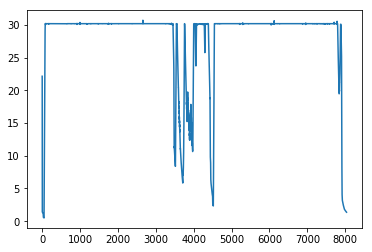

In [4]:
plt.plot(simulation_data['speed'])

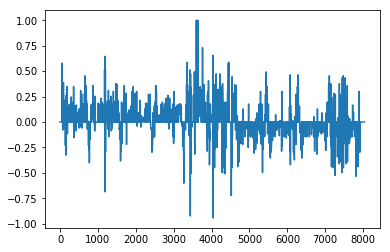

In [5]:
plt.plot(simulation_data['steering'])

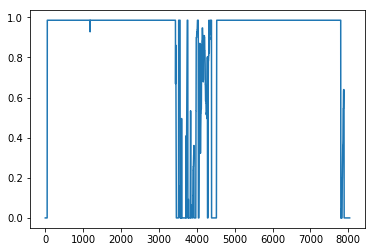

In [6]:
plt.plot(simulation_data['throttle'])

From the dataset collected we find that there is a lot of variation in the steering angles of the car and the values lie between -1 and 1. at the same time we find that the speed and throttle of the car seems to remain fairly constant except for the part of the graph where the the steering angles vary alot. our aim should be to mimic the steering behaviour as expressed by the graph. we can use that as a reliable guide to tell if the network is learning or not.

## image exploration

In [7]:
no_turn = simulation_data[simulation_data['steering'] == 0.0 ].iloc[0]
left_turn = simulation_data[(simulation_data['steering'] >= 0.6) & (simulation_data['steering'] <= 1.0) ].iloc[0]
right_turn = simulation_data[(simulation_data['steering'] >= -1) & (simulation_data['steering'] <= -0.6) ].iloc[0]

In [8]:
def plot_images_from_row(row, image_preprocess=lambda x: x):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
    image = plt.imread(data_directory+ row['left'].strip())
    ax1.imshow(image_preprocess(image))
    ax1.grid(False)
    
    image = plt.imread(data_directory+ row['center'])
    ax2.imshow(image_preprocess(image))
    ax2.grid(False)
    image = plt.imread(data_directory+ row['right'].strip())
    ax3.imshow(image_preprocess(image))
    ax3.grid(False)

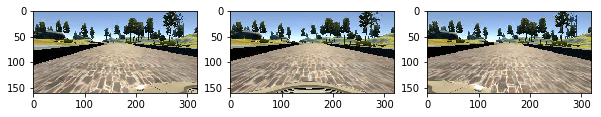

In [9]:
plot_images_from_row(no_turn)

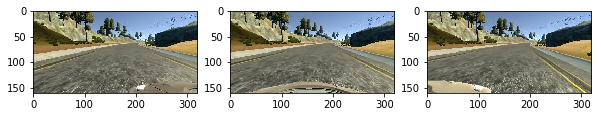

In [10]:
plot_images_from_row(left_turn)

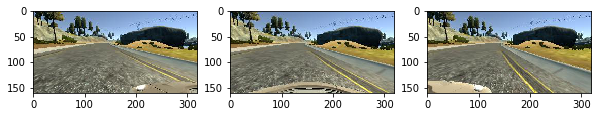

In [11]:
plot_images_from_row(right_turn)

from the initial observation of the images we see that the bottom part of the images contain the image of the car, i chose to crop the image so that the images can be used for data augmentation to create recovery scenarios for the car

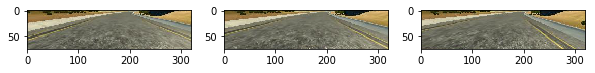

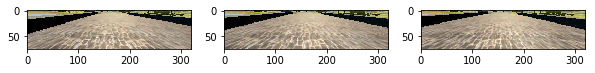

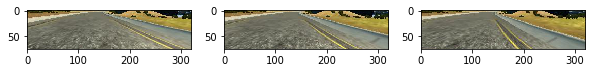

In [12]:
def crop_image(image, top=60, bottom=135):
    return image[top:bottom]

plot_images_from_row(left_turn, crop_image)
plot_images_from_row(no_turn, crop_image)
plot_images_from_row(right_turn, crop_image)

Let's also observe the images in different color spaces to see if a different representation helps segment the features more obvious

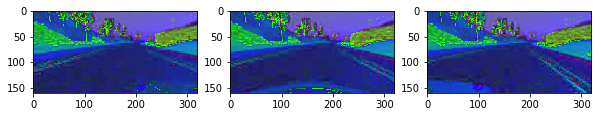

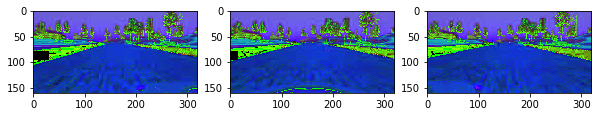

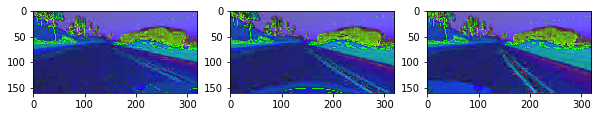

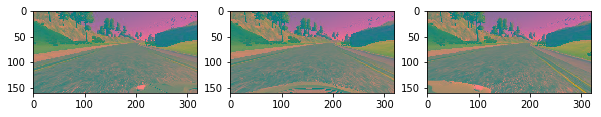

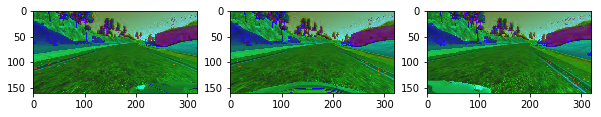

In [13]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plot_images_from_row(left_turn, convert_to_hsv)
plot_images_from_row(no_turn, convert_to_hsv)
plot_images_from_row(right_turn, convert_to_hsv)
def convert_to_yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_images_from_row(left_turn, convert_to_yuv)

def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
plot_images_from_row(left_turn, convert_to_hls)

## Data Augmentation
In this section I explore some methods to augment the precollected data to improve the generalization capabilities of the models.
The ideas explored include :
 * turn angle adjustments using the left / right camera images
 * brightness adjustments
 * translations on y axis to create impression of uphill and downhill movement


In [14]:
def preprocess_function(image):
    
    return cv2.resize(crop_image(image),(224, 49), interpolation= cv2.INTER_AREA)

def load_image(src, preprocess_function=preprocess_function):
    image = plt.imread(src)
    return preprocess_function(image)

all_images = []
for img_src in tqdm(simulation_data['center']):
    all_images.append(load_image(data_directory+img_src.strip()))

for img_src in tqdm(simulation_data['left']):
    all_images.append(load_image(data_directory+img_src.strip()))

for img_src in tqdm(simulation_data['right']):
    all_images.append(load_image(data_directory+img_src.strip()))


100%|██████████| 8036/8036 [00:12<00:00, 650.72it/s]


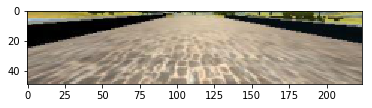

In [15]:
plt.imshow(all_images[0])

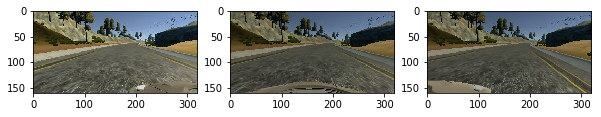

In [16]:
def augment_brightness(image):
    change_pct = np.random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_brightness

plot_images_from_row(left_turn, augment_brightness)

In [18]:
all_images = np.asarray(all_images)
brightness_augmented = np.asarray([augment_brightness(image) for image in all_images])
all_images = np.append(all_images,brightness_augmented, axis=0)
all_images = np.append(all_images,all_images[:,:,::-1],axis=0)

In [19]:
steering_angles = simulation_data['steering']
steering_left = steering_angles.copy().apply(lambda x: min(1,x+0.3))
steering_right = steering_angles.copy().apply(lambda x: max(-1,x-0.3))
steering_angles = steering_angles.append(steering_left)
steering_angles = steering_angles.append(steering_right)


In [20]:
steering_angles = np.asarray(steering_angles)
# for brightness augmentation
steering_angles = np.append(steering_angles,steering_angles,axis=0)

# for flipping
steering_angles = np.append(steering_angles,-steering_angles,axis=0)

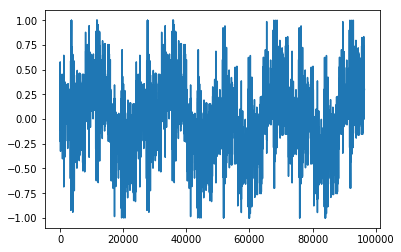

In [21]:
plt.plot(steering_angles)

In [27]:
all_images.shape

(96432, 49, 224, 3)

We split the steering angle augmented dataset into the training and validation sets, the brightness augmentation and the y translations are done using the keras dataset fit generator.

In [28]:
X_train, X_test, y_train , y_test = train_test_split(all_images, steering_angles, test_size=0.1)

I also horizontally flip all the data and reverse the corresponding steering angles. 

In [37]:
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

In [36]:
train_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(86788, 49, 224, 3)
(9644, 49, 224, 3)
(86788,)
(9644,)


## Machine learning models
since the values of the steering angles are continuous valus between -1 and +1 we know that predicting the angle is essentially a regression task. a working solution to this problem was published by Nvidia in the paper (End to End Learning for Self-Driving Cars) https://arxiv.org/abs/1604.07316. I experiment by comparing the nvidia model along with a transfer learning from VGG16.

#### 1. Nvidia End to End Learning model


In [47]:
model_a = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(49,224,3)),
        Convolution2D(3, 1,1, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.1),
        Convolution2D(32, 5 , 5, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Convolution2D(64, 5 , 5, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Convolution2D(64, 3 , 3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='tanh'),
        Dropout(0.2),
        Dense(1),
    ])
model_a.compile(optimizer=Adam(), loss='mse')
model_a.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 49, 224, 3)    0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 49, 224, 3)    12          lambda_3[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 24, 112, 3)    0           convolution2d_9[0][0]            
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 24, 112, 3)    0           maxpooling2d_9[0][0]             
___________________________________________________________________________________________

#### 2.  VGG16 feature transfer

In [ ]:
vgg_features = VGG16(include_top=False, input_shape=(49, 224, 3), weights='imagenet')
vgg_model = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(49,224,3)),
    ])
for l in vgg_features.layers:
    l.trainable = False
vgg_model.add(vgg_features)

vgg_model.add(Flatten())
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(10, activation='tanh'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1))
vgg_model.compile(loss='mse', optimizer=Adam())
vgg_model.summary()

I trained both models using the training datasets and evaluate on the mean square error metric

In [48]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
model_a.fit_generator(batches, batches.n, nb_epoch=25, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/25
86788/86788 [==============================] - 188s - loss: 0.0457 - val_loss: 0.0317
Epoch 2/25
86788/86788 [==============================] - 183s - loss: 0.0321 - val_loss: 0.0287
Epoch 3/25
86788/86788 [==============================] - 185s - loss: 0.0296 - val_loss: 0.0256
Epoch 4/25
86788/86788 [==============================] - 185s - loss: 0.0283 - val_loss: 0.0252
Epoch 5/25
86788/86788 [==============================] - 184s - loss: 0.0271 - val_loss: 0.0234
Epoch 6/25
86788/86788 [==============================] - 184s - loss: 0.0266 - val_loss: 0.0238
Epoch 7/25
86788/86788 [==============================] - 183s - loss: 0.0259 - val_loss: 0.0228
Epoch 8/25
86788/86788 [==============================] - 184s - loss: 0.0250 - val_loss: 0.0216
Epoch 9/25
86788/86788 [==============================] - 184s - loss: 0.0241 - val_loss: 0.0198
Epoch 10/25
86788/86788 [==============================] - 184s - loss: 0.0222 - val_loss: 0.0172
Epoch 11/25
86788/86788 [====

In [48]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
vgg_model.fit_generator(batches, batches.N, nb_epoch=10, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/10
43394/43394 [==============================] - 234s - loss: 0.7160 - val_loss: 0.1016
Epoch 2/10
43394/43394 [==============================] - 228s - loss: 0.1912 - val_loss: 0.0581
Epoch 3/10
43394/43394 [==============================] - 228s - loss: 0.0852 - val_loss: 0.0472
Epoch 4/10
43394/43394 [==============================] - 229s - loss: 0.0528 - val_loss: 0.0444
Epoch 5/10
43394/43394 [==============================] - 229s - loss: 0.0393 - val_loss: 0.0270
Epoch 6/10
43394/43394 [==============================] - 228s - loss: 0.0332 - val_loss: 0.0364
Epoch 7/10
43394/43394 [==============================] - 229s - loss: 0.0308 - val_loss: 0.0268
Epoch 8/10
43394/43394 [==============================] - 228s - loss: 0.0293 - val_loss: 0.0266
Epoch 9/10
43394/43394 [==============================] - 228s - loss: 0.0283 - val_loss: 0.0279
Epoch 10/10
43394/43394 [==============================] - 228s - loss: 0.0282 - val_loss: 0.0295


While the MSE metric was used to evaluate the model during training, I decided to visualize what the network predicts when given the the ordered dataset, this will help judge how stable the vehicle will drive on the track.

In [49]:
ordered_track = []
for img_src in tqdm(simulation_data['center']):
    ordered_track.append(load_image(data_directory+img_src.strip()))

100%|██████████| 8036/8036 [00:12<00:00, 648.75it/s]


In [50]:
ordered_track  = np.asarray(ordered_track)

In [51]:
nvidia_model_predictions = model_a.predict(ordered_track, batch_size=128)

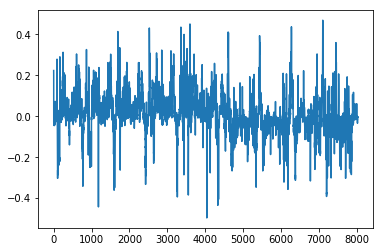

In [52]:
plt.plot(nvidia_model_predictions)

In [49]:
vgg_model_predictions = vgg_model.predict(ordered_track, batch_size=128)

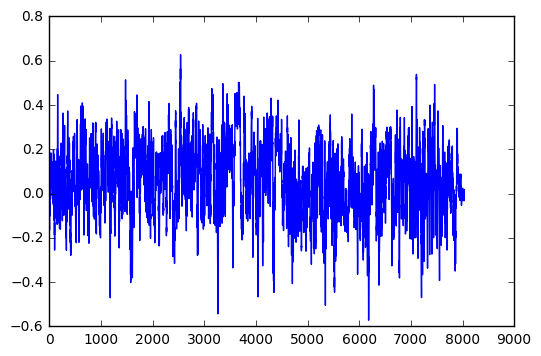

In [50]:
plt.plot(vgg_model_predictions)

Saving the models to the models/unregularized directory

In [54]:
%mkdir "models"
%mkdir "models/unregularized"


In [55]:
unregularized_dir = "models/unregularized/"

model_json = model_a.to_json()
with open(unregularized_dir+"nvidia_model.json", "w") as json_file:
    json_file.write(model_json)

model_a.save_weights(unregularized_dir+"nvidia_model.h5")
print("Saved model to disk")


Saved model to disk


In [56]:
unregularized_dir = "models/unregularized/"
model_json = vgg_model.to_json()
with open(unregularized_dir+"vgg_model.json", "w") as json_file:
    json_file.write(model_json)

vgg_model.save_weights(unregularized_dir+"vgg_model.h5")
print("Saved model to disk")

Saved model to disk
